In [1]:
from os import listdir
from os.path import isdir
from numpy import asarray
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

## Pre -Processing functions

In [2]:
# image resize
#resnet50 224
#inception , xception 299

def image_resize(path, input_size=224):
    img = tf.keras.preprocessing.image.load_img(path, grayscale=False, color_mode='rgb', target_size=(input_size, input_size),interpolation='nearest')
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img = np.array(img_arr)
    #print(img_arr.shape)
    return img

In [3]:
#0=exchange Paper, 1=looking at friend, 2=Talking Friend, 3=Use Cheat Sheet, 4=No Cheat
labels = ("exchange Paper" , "looking at friend" , "Talking Friend", "Use Cheat Sheet", "No Cheat")
len(labels)

5

In [4]:
# load datasets


def load_datasets(dataset_directory,input_size=224):
    files = list()
    labels = list()
    a = 0
    for folder in listdir(dataset_directory):
        #get path
        path_folder = dataset_directory + folder + '/'
        #load faces in the path_folder
        if not isdir(path_folder):
            continue
            
        if len(folder) == len("exchange Paper"):
            a = 0
        elif len(folder) == len("looking at friend"):
            a = 1
        elif len(folder) == len("Talking Friend"):
            a = 2
        elif len(folder) == len("Use Cheat Sheet"):
            a = 3
        elif len(folder) == len("No Cheat"):
            a = 4
        
        for filename in listdir(path_folder):
            #img = cv2.imread(path_folder+filename)
            img = image_resize(path_folder+filename,input_size)
            files.append(img)
            labels.append(a)
            #for key, val in labels.items():
                #if val is folder:
                    #labels.append(key)
        
        print(">loaded {} examples for class: {}" .format(len(files), folder))
        
    return asarray(files), asarray(labels)

## resnet50 model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
!unzip -uq "/content/drive/My Drive/datasets/cheating.zip" -d "/content/drive/My Drive/datasets"

## Load datasets: train and test sets

In [8]:
# load train set

print('Load train set:')
x_train, y_train = load_datasets("/content/drive/My Drive/datasets/cheating/train/")

Load train set:
>loaded 24 examples for class: exchange Paper
>loaded 90 examples for class: looking at friend
>loaded 104 examples for class: Talking Friend
>loaded 128 examples for class: Use Cheat Sheet
>loaded 198 examples for class: No Cheat


In [9]:
print(x_train.shape, y_train.shape)

(198, 224, 224, 3) (198,)


In [10]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [11]:
# load test set

print('Load test set:')
x_test, y_test = load_datasets("/content/drive/My Drive/datasets/cheating/test/")

Load test set:
>loaded 0 examples for class: giving code
>loaded 9 examples for class: exchange Paper
>loaded 38 examples for class: looking at friend
>loaded 72 examples for class: No Cheat
>loaded 78 examples for class: Talking Friend
>loaded 92 examples for class: Use Cheat Sheet


In [12]:
from sklearn.model_selection import train_test_split

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.8, test_size=0.2, random_state=101)

In [13]:
print(x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(73, 224, 224, 3) (73,) (19, 224, 224, 3) (19,)


## Create Model

In [14]:
#weight_decay = 0.00005
#l2=tf.keras.regularizers.l2
def Model(base_model = ResNet50, input_size = 224):
    baseModel = base_model(weights="imagenet", include_top=False,input_tensor=tf.keras.layers.Input(shape=(input_size, input_size, 3)))

    _model = baseModel.output
    _model = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(_model)
    _model = tf.keras.layers.Flatten(name="flatten")(_model)
    _model = tf.keras.layers.Dense(512, activation="relu")(_model)
    _model = tf.keras.layers.Dropout(0.5)(_model)
    _model = tf.keras.layers.Dense(len(labels), activation="softmax")(_model)
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = tf.keras.models.Model(inputs=baseModel.input, outputs=_model)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the training process
    for layer in baseModel.layers:
        layer.trainable = True
    
    return model, input_size

In [15]:
model, input_size = Model()

94773248/94765736 [==============================] - 1s 0us/step


In [16]:
# set batch size and epoch
epochs = 50
batch_size = 64

In [17]:
x_train = x_train.reshape(x_train.shape[0], input_size, input_size, 3)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], input_size, input_size, 3)
x_test = x_test.astype('float32')
x_val = x_val.reshape(x_val.shape[0], input_size, input_size, 3)
x_val = x_val.astype('float32')

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

train_size = len(x_train)
val_size = len(x_val)

print(y_test.shape)
print(y_test)

(73, 5)
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [

In [18]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = generator.flow(x_train, y_train, batch_size=batch_size)
val_generator = generator.flow(x_val, y_val, batch_size=batch_size)

model.compile(loss='categorical_crossentropy'
, optimizer=tf.keras.optimizers.Adam()
, metrics=['accuracy']
)

#model.load_weights('/home/kevin/spyder-workspace/EXAM_MONITORING/notebook/models/H_A_R/weights.hdf5')

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [19]:
histories = model.fit(train_generator,validation_data= val_generator, steps_per_epoch=train_size//batch_size, epochs=epochs, validation_steps = val_size//batch_size)

Epoch 1/500
12/12 [==============================] - 3s 273ms/step - loss: 1.9646 - accuracy: 0.4011 - val_loss: 14.5034 - val_accuracy: 0.1875
Epoch 2/500
12/12 [==============================] - 2s 167ms/step - loss: 1.3579 - accuracy: 0.5549 - val_loss: 51.9240 - val_accuracy: 0.3125
Epoch 3/500
12/12 [==============================] - 2s 170ms/step - loss: 1.4705 - accuracy: 0.5385 - val_loss: 94.1315 - val_accuracy: 0.4375
Epoch 4/500
12/12 [==============================] - 2s 175ms/step - loss: 1.2813 - accuracy: 0.5312 - val_loss: 579.5033 - val_accuracy: 0.2500
Epoch 5/500
12/12 [==============================] - 2s 167ms/step - loss: 1.0607 - accuracy: 0.6264 - val_loss: 410.1007 - val_accuracy: 0.3125
Epoch 6/500
12/12 [==============================] - 2s 169ms/step - loss: 0.7478 - accuracy: 0.7363 - val_loss: 17.2780 - val_accuracy: 0.2500
Epoch 7/500
12/12 [==============================] - 2s 169ms/step - loss: 0.7097 - accuracy: 0.7637 - val_loss: 13.1410 - val_accurac

In [20]:
model.save('/content/drive/My Drive/models/H_A_R_weights.hdf5')

In [21]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.007123906165361404
Train accuracy: 99.49495196342468
Test loss: 3.3555545806884766
Test accuracy: 67.12328791618347


In [22]:
import cv2

test_img = image_resize("/content/drive/My Drive/datasets/teencheating.jpg")
print(test_img.shape)
test_img= np.expand_dims(test_img, axis=0)
test_img = test_img.astype('float32')
test_img /= 255
print(test_img.shape)
pred = model.predict(test_img)
print(pred)
print(max(max(pred)))

(224, 224, 3)
(1, 224, 224, 3)
[[9.9999976e-01 6.4341847e-08 3.4884652e-15 3.4587791e-10 1.3410876e-07]]
0.99999976


In [23]:
print(y_test[:3])

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [24]:
def pred_activty(path, i = 0):

  test_img = image_resize(path)
  print(test_img.shape)
  test_img= np.expand_dims(test_img, axis=0)
  test_img = test_img.astype('float32')
  test_img /= 255
  print(test_img.shape)
  pred = model.predict(test_img)

  pred_res = pred[0]
  pred_max = max(pred_res)

  # index
  indice_max = -1
  for i in range(len(pred_res)):
    if pred_res[i] == pred_max:
      indice_max = i
      print(indice_max)
  
  import cv2
  import matplotlib.pyplot as plt
  frame = cv2.imread(path)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # draw the predicted activity on the frame
  cv2.rectangle(frame, (0, 0), (300, 40), (0, 0, 0), -1)
  cv2.putText(frame, labels[indice_max], (10, 25), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
  plt.imshow(frame)
  plt.savefig("/content/drive/My Drive/reports/result_teencheating" + str(i) +".jpg")



(224, 224, 3)
(1, 224, 224, 3)
0


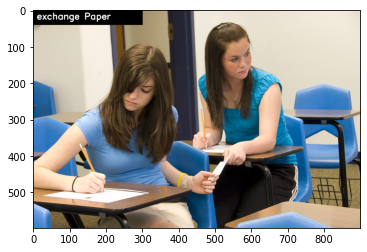

In [25]:
pred_activty("/content/drive/My Drive/datasets/teencheating.jpg",0)

(224, 224, 3)
(1, 224, 224, 3)
1


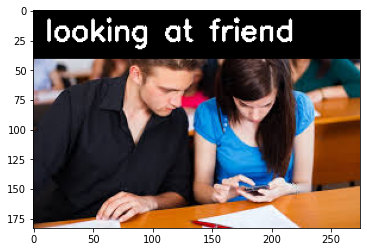

In [26]:
pred_activty("/content/drive/My Drive/datasets/images.jpeg",1)

(224, 224, 3)
(1, 224, 224, 3)
1


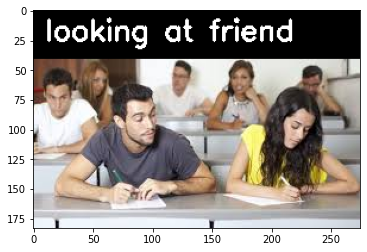

In [27]:
pred_activty("/content/drive/My Drive/datasets/images_2.jpeg",2)

(224, 224, 3)
(1, 224, 224, 3)
1


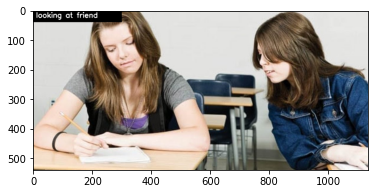

In [28]:
pred_activty("/content/drive/My Drive/datasets/images_3.jpg",3)

(224, 224, 3)
(1, 224, 224, 3)
1


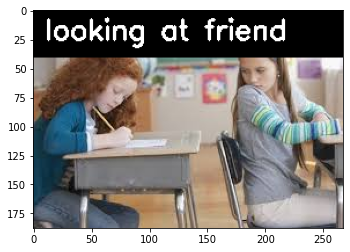

In [29]:
pred_activty("/content/drive/My Drive/datasets/images_1.jpeg",4)

In [30]:
pred_res = pred[0]

In [31]:
pred_max = max(pred_res)
pred_max

0.99999976

In [32]:
# index
indice_max = -1
for i in range(len(pred_res)):
  if pred_res[i] == pred_max:
    indice_max = i
    print(indice_max)


0


In [33]:
labels[indice_max]

'exchange Paper'

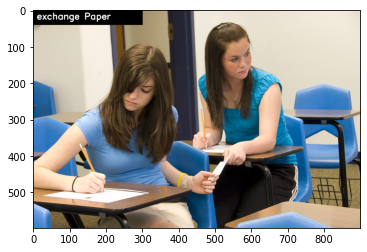

In [34]:
import cv2
import matplotlib.pyplot as plt
frame = cv2.imread("/content/drive/My Drive/datasets/teencheating.jpg")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# draw the predicted activity on the frame
cv2.rectangle(frame, (0, 0), (300, 40), (0, 0, 0), -1)
cv2.putText(frame, labels[indice_max], (10, 25), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 255, 255), 2)
plt.imshow(frame)
plt.savefig("/content/drive/My Drive/reports/result_teencheating.jpg")

In [35]:
from matplotlib import pyplot as plt

In [42]:
y_test[0]

array([0., 1., 0., 0., 0.], dtype=float32)